In this exercise we will use a cloud-free remote sensing image to extract, count, and inspect lakes in Kansas. You can use the same principles to delineate other features. This exercise is at teh intersection of image analysis and spatial analysis.

#### Data source:

Download GeoTiff image for the state of Kansas on 14-February-2022 from NASA Worldview Snapshots: https://wvs.earthdata.nasa.gov/

We will use the image from the MODIS Terra satellite with the following bands:
- Band 7 = 2155 nm (Red channel)
- Band 2 = 876 nm  (Green channel)
- Band 1 = 670 nm  (Blue channel)

In this image:

- Vegetation appears bright green. Vegetation is very reflective in Band 2 (reason why it was assigned to the green channel)
- Liquid water: Black or dark blue
- Desert/Naturally bare soil: Sandy pink
- Burn scar: Red to reddish-brown
- Snow and ice are very reflective in band 7
- Ice and snow appear as bright turquoise
- Clouds appear white


In [1]:
# Import modules
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import numpy as np
from skimage.morphology import area_opening, binary_closing, disk
from skimage.measure import find_contours, label, regionprops_table



In [3]:
# Read the GeoTiff file
raster = rasterio.open('../datasets/spatial/snapshot-2022-02-14.tiff')


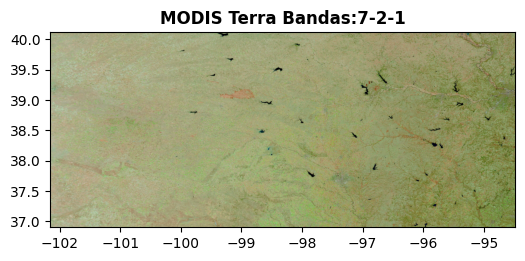

In [4]:
# Display the map
plt.figure(figsize=(6,4))
show(raster, title='MODIS Terra Bandas:7-2-1')
plt.show()


In [5]:
# Inspect some properties of the image
print('Data type:', raster.dtypes)
print('Shape of the image:', raster.shape)
print('Image width',raster.width)
print('Image height',raster.height)
print('Bands', raster.indexes)
print('Bounding box',raster.bounds)
print('Missing values', raster.nodatavals)
print('CRS', raster.crs)

# Show raster metadata
print(raster.meta)

Data type: ('uint8', 'uint8', 'uint8')
Shape of the image: (1465, 2733)
Image width 2733
Image height 1465
Bands (1, 2, 3)
Bounding box BoundingBox(left=-102.14937187828008, bottom=36.900982382252316, right=-94.47619487827995, top=40.12014738225228)
Missing values (None, None, None)
CRS EPSG:4326
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2733, 'height': 1465, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0028076022685693805, 0.0, -102.14937187828008,
       0.0, -0.0021973822525597, 40.12014738225228)}


In [7]:
# Learn how to convert specific rows and columns into lon and lat
raster.xy(row=0, col=0)

(-102.14796807714579, 40.119048691126)

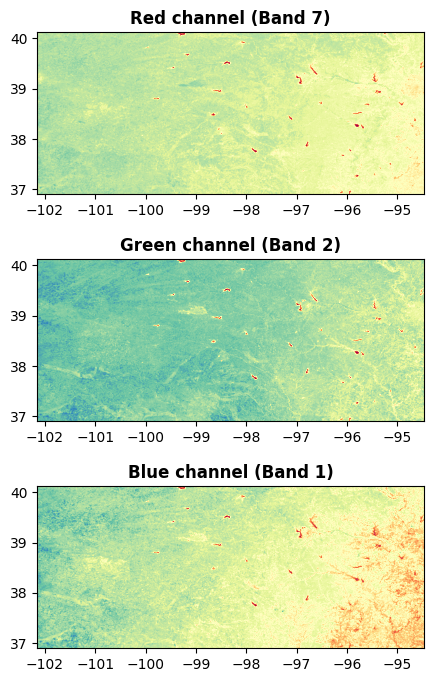

In [11]:
# Plot the three bands
fig, (ax_red, ax_green, ax_blue) = plt.subplots(3,1, figsize=(6,8))
show( (raster, 1), ax=ax_red, cmap='Spectral', title='Red channel (Band 7)' )
show( (raster, 2), ax=ax_green, cmap='Spectral', title='Green channel (Band 2)' )
show( (raster, 3), ax=ax_blue, cmap='Spectral', title='Blue channel (Band 1)' )
fig.subplots_adjust(hspace=0.4)
plt.show()


In [41]:
# Inspect pixel values for a point on Milford Lake, KS

# Define point
lat = 39.100000 
lon = -96.934662

# Getpoint x (columns) and y (row) coordinates
py,px = raster.index(lon, lat)

# Get R, G, and B values for the point
pix_red = raster.read(1)[py, px]
pix_green = raster.read(2)[py, px]
pix_blue = raster.read(3)[py, px]
print(pix_red, pix_green, pix_blue)


1 1 3


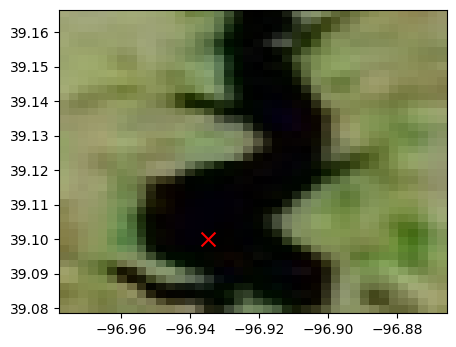

In [42]:
# Plot a small patch of land
# Syntax: rasterio.windows.Window(col_off, row_off, width, height) or 

window = rasterio.windows.Window(px-15, py-30, width=40, height=40)
window_data = raster.read(window=window)
#window_data = raster.read(window=rasterio.windows.from_bounds(-96.93, 39.0, -96.83, 39.1, raster.transform))

# Get the transform for the window
window_transform = raster.window_transform(window)

fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(lon, lat, marker='x', color='r', s=100)
show(small_window, transform=window_transform, ax=ax)
plt.show()


In [51]:
# Classify the lakes using thresholding of second band
BW = raster.read(2) < 25


In [52]:
# Filter image
BW = area_opening(BW, area_threshold=100, connectivity=1)
BW = binary_closing(BW, disk(5))


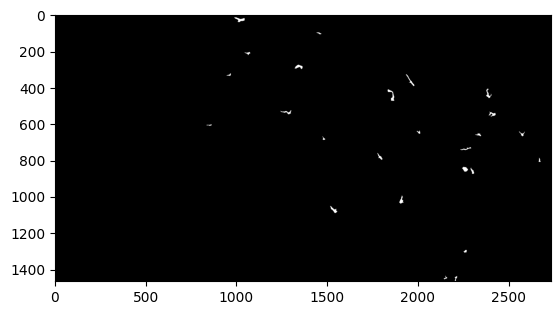

In [53]:
# Show classified boolean image
plt.figure()
plt.imshow(BW, cmap='binary_r')
plt.show()


In [54]:
# Find percentage of the area covered by lakes
print('Area of the state covered by lakes:', BW.sum()/BW.size*100)


Area of the state covered by lakes: 0.2117964107002144


In [55]:
# Area of water bodies
pixel_area = 0.25**2
print('Total area with water bodies:',BW.sum()*pixel_area)


Total area with water bodies: 530.0


In [56]:
# Find lake contours
contours = find_contours(BW)
print('Detected:', len(contours), 'lakes')


Detected: 25 lakes


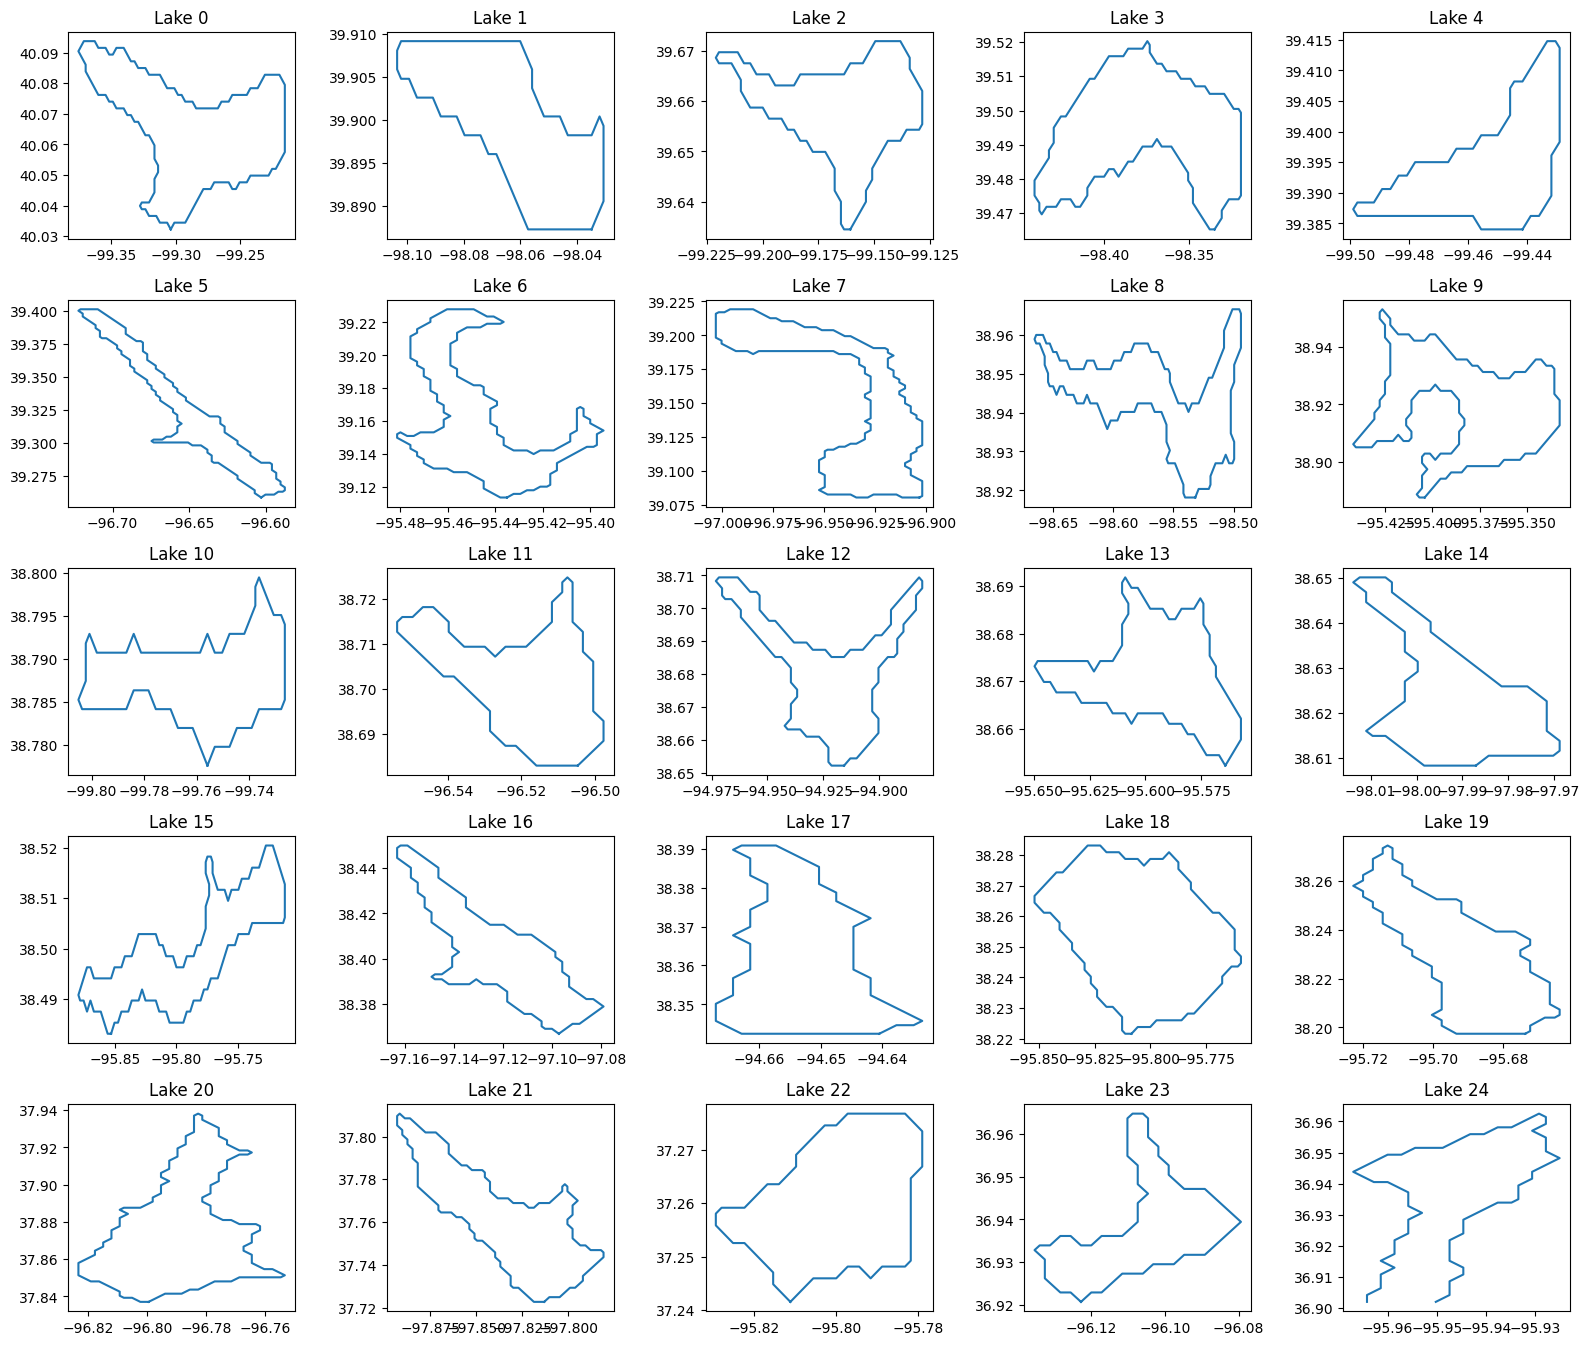

In [57]:
# Create a figure with the plot of each lake
plt.figure(figsize=(16,16))

for k,contour in enumerate(contours):
    plt.subplot(6,5, k+1)
    plt.title(f'Lake {k}')
    lon,lat = raster.xy(contour[:,0], contour[:,1])
    plt.plot(lon, lat)
    plt.tight_layout()
    
plt.show()


In [58]:
# Create table with properties for each lake
props = regionprops_table(label(BW), properties=('centroid','area'))
props = pd.DataFrame(props)
props['area'] = props['area']*250*250/10_000
props.head()


,centroid-0,centroid-1,area
0,24.872493,1019.070201,4362.50
1,100.059259,1455.014815,843.75
2,210.040909,1062.936364,1375.00
3,284.822262,1343.484740,3481.25
4,329.584507,960.176056,887.50


In [59]:
# Sort dataframe by area
props.sort_values(by='area', ascending=False, inplace=True)
props.reset_index(drop=True, inplace=True)
props.head()


,centroid-0,centroid-1,area
0,441.670270,1854.944595,4625.00
1,24.872493,1019.070201,4362.50
2,284.822262,1343.484740,3481.25
3,848.783002,2259.473779,3456.25
4,1073.158965,1536.297597,3381.25


In [60]:
# Get the centroid row and column and obtain the corresponding longitude and latitude
lon_largest, lat_largest = raster.xy(props['centroid-0'].iloc[0], props['centroid-1'].iloc[0])


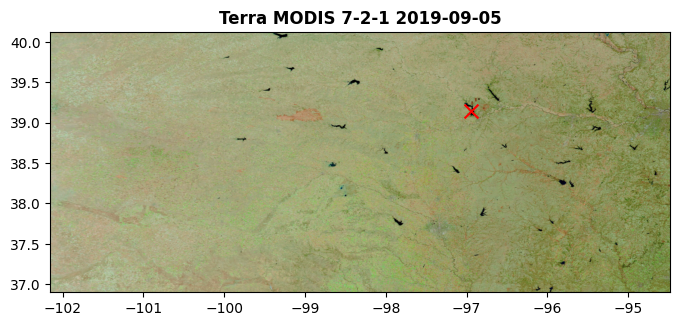

In [61]:
plt.figure(figsize=(8,6))
plt.scatter(lon_largest, lat_largest, marker='x', color='r', s=100)
show(raster, title='Terra MODIS 7-2-1 2019-09-05')
plt.show()

## Save image with identified lakes

In [52]:
# Save resulting BW array as a raster map
profile = raster.profile
profile.update(count=1)
with rasterio.open('lakes.tiff', 'w', **profile) as f:
    f.write(BW, 1)


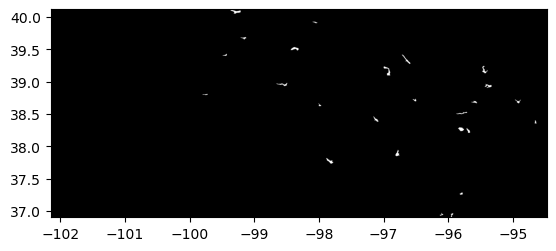

In [56]:
# Read the lakes GeoTiff back into Python and display map (noticed that now the images has coordinates)
lakes = rasterio.open('lakes.tiff')
show(lakes, cmap='gray')
plt.show()
